In [1]:
import numpy as np
import importlib
import time
import glob
%matplotlib nbagg
# %matplotlib qt
# %matplotlib
# %matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import scipy
import tensorflow as tf
import hyperspy.api as hs

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="1" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
# free space from GPU device
from numba import cuda
cuda.select_device(0)
cuda.close()

In [4]:
from keras import applications, optimizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [5]:
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData_noFeatureCenter.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData_smallShift.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_WhiteNoise.h5'
# model_path = 'CNNmodels/VGG16_usim_40mradEmit+defocus_noApt.h5'
# model_path = 'CNNmodels/VGG16_nion_30mradEmit+defocus_28mradApt.h5'
model_path = 'CNNmodels/VGG16_nion_midAbr_30mradEmit+defocus_28mradApt.h5'
# model_path = 'CNNmodels/VGG16_30mrademit+defocus_30mradApt_lowAbr_test12_05.h5' 

In [6]:
model = applications.VGG16(weights=None, include_top=False, input_shape=(128, 128, 3))
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(1,activation=None))
new_model = Sequential()

for l in model.layers:
    new_model.add(l)

new_model.add(top_model)
new_model.load_weights(model_path)

In [7]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [8]:
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [9]:
def scale_range_aperture(input, min, max):
    hist, bin_edges = np.histogram(np.ndarray.flatten(frame), bins = 'auto')
    idx = np.argmin(abs(np.gradient(hist)[0:len(hist)//2]))
    threshold = bin_edges[idx]
    input += -threshold
    input[input<0] = 0
    input /= np.max(input) / (max - min)
    input += min
    return input

In [15]:
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30", 
"C32.x", "C32.y", "C34.x", "C34.y"]

abr_lim = [2e-6, 1.5e-6, 1.5e-6, 3e-5, 3e-5, 1e-5, 1e-5, 3e-4, 2e-4, 2e-4, 1.5e-4, 1.5e-4]
abr_default = [2e-9, 2e-9, 2e-9, 20e-9, 20e-9, 20e-9, 20e-9, 0.5e-6, 1e-6, 1e-6, 1e-6, 1e-6]

In [16]:
# Analyze different dwell time, and the standard deviation with each dwell time
abr_coeff = 'C12.x'
dwell_list = [25, 50, 100, 250, 500]
file_list = []
for dwell_time in dwell_list:
    path = '../NionData/voaFOV_C12linescans/'
#     path = '../NionData/LineScans_070121/'+str(dwell_time)+'ms/'
    file_list.append(glob.glob(path + abr_coeff +'*'+str(dwell_time)+'ms_bin1_repx5voaFOV.npy')[0])
print(file_list)

['../NionData/voaFOV_C12linescans/C12.x_1.5e-06m_100steps_25ms_bin1_repx5voaFOV.npy', '../NionData/voaFOV_C12linescans/C12.x_1.5e-06m_100steps_50ms_bin1_repx5voaFOV.npy', '../NionData/voaFOV_C12linescans/C12.x_1.5e-06m_100steps_100ms_bin1_repx5voaFOV.npy', '../NionData/voaFOV_C12linescans/C12.x_1.5e-06m_100steps_250ms_bin1_repx5voaFOV.npy', '../NionData/voaFOV_C12linescans/C12.x_1.5e-06m_100steps_500ms_bin1_repx5voaFOV.npy']


In [25]:
abr_coeff = 'C12.y'
dwell_time = 250
path = '../NionData/LineScans_250ms_070421/'
file_list = glob.glob(path + abr_coeff +'*'+str(dwell_time)+'ms_bin1_repx5voaFOV.npy')
print(file_list)

['../NionData/LineScans_250ms_070421/C12.y_1.5e-06m_100steps_250ms_bin1_repx5voaFOV.npy']


In [26]:
# ronch_list = np.load('NionRelated/C12.y_2e-06m_100steps_10ms_bin8.npy')
nsteps = 100
nrep = 5
x_list = []
y_list = []
t_list = []
coeff_list = []
x_default = [(abr_default[i] + abr_lim[i]/2) / abr_lim[i] for i in range(len(abr_list))]

for file in file_list:
    name_list = file.replace('/','_').split('_')
    print(file, name_list)
    abr_coeff = name_list[5]
    idx = abr_list.index(abr_coeff)
    abr_range = abr_lim[idx]
    value_list = [(i - nsteps//2) * abr_range / nsteps for i in range(nsteps)]
    ronch_list = np.load(file)
    frame_list = []
#     print(abr_range, value_list)
    
    for i in range(nsteps):
        for j in range(nrep):
            x = [x_default[j] for j in range(len(x_default))]
            x[idx] = (value_list[i] + abr_range / 2) / abr_range
            x_list.append(x)
            frame = ronch_list[i * nrep + j,:,:]
            frame = scale_range_aperture(frame, 0, 1)
    #         frame = frame * aperture_generator(128, 50, 40)
            new_channel = np.zeros(frame.shape)
            img_stack = np.dstack((frame, new_channel, new_channel))
            frame_list.append(img_stack)
    frame_list = np.concatenate([arr[np.newaxis] for arr in frame_list])
    prediction = new_model.predict(frame_list, batch_size = 1)
    y_list.append((prediction[:,0])[:])
    t_list.append(name_list[-3])
    coeff_list.append(abr_coeff)

../NionData/LineScans_250ms_070421/C12.y_1.5e-06m_100steps_250ms_bin1_repx5voaFOV.npy ['..', 'NionData', 'LineScans', '250ms', '070421', 'C12.y', '1.5e-06m', '100steps', '250ms', 'bin1', 'repx5voaFOV.npy']


<IPython.core.display.Javascript object>


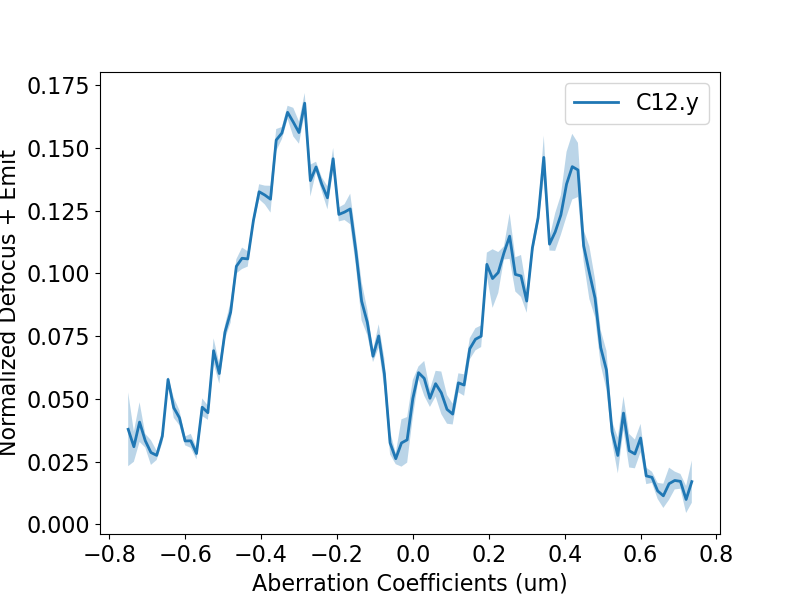

In [27]:
fig, ax = plt.subplots(1,1, figsize = [8,6])
y_list_avg = []
x_list_avg = np.array(x_list[::5])
std_list = np.zeros(nsteps)

for i in range(len(t_list)):
    temp = y_list[i].reshape([nsteps, 5])
    y_list_avg.append(temp.mean(-1))
    for j in range(nsteps):
        std_list[j] = np.std(temp[j,:])
    p = ax.plot(np.array(value_list) * 1e6, temp.mean(-1), linewidth = 2, label = coeff_list[i])
    ax.fill_between(np.array(value_list) * 1e6, temp.mean(-1) - np.array(std_list), 
                    temp.mean(-1) + np.array(std_list), alpha = 0.3)

ax.set_xlabel('Aberration Coefficients (um)',fontsize = 16)
ax.set_ylabel('Normalized Defocus + Emit', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize = 16)

<IPython.core.display.Javascript object>


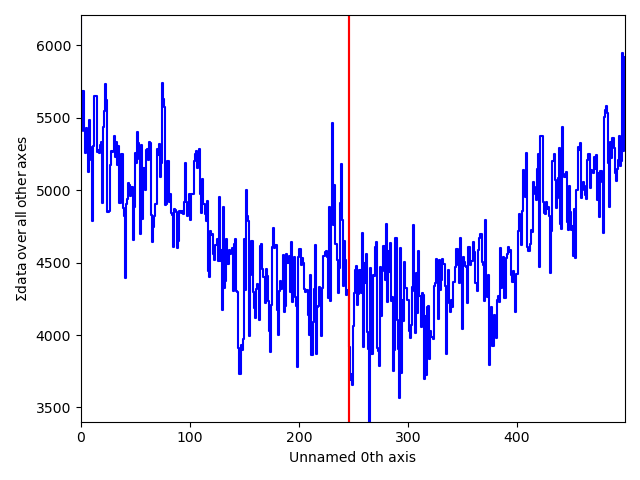

<IPython.core.display.Javascript object>


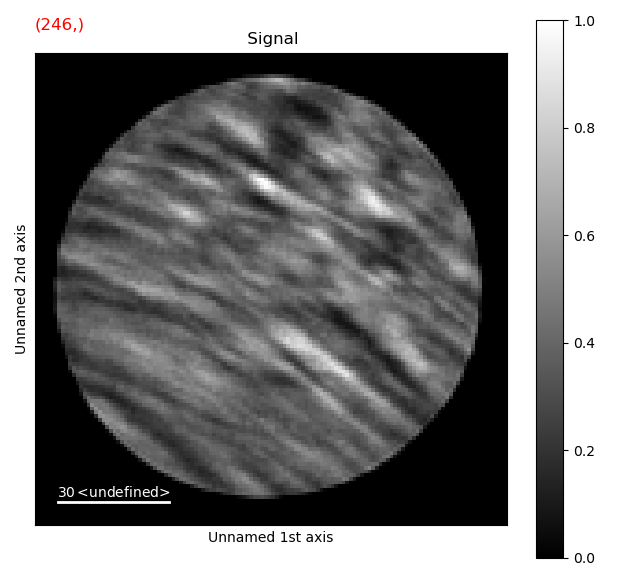

In [28]:
im = hs.signals.Signal2D(np.array(ronch_list))
im.plot()

In [32]:
fig, ax = plt.subplots(1,1, figsize = [8,6])
img = ax.imshow(ronch_list[10], extent = [-50, 50, -50, 50], cmap = "gray")
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('$a_x$',fontsize = 16)
ax.set_ylabel('$a_y$', fontsize = 16)
cbar = fig.colorbar(img, ax=ax, shrink=0.9)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=14)
# cbar.ax.set_ylabel('Emittance^2',fontsize = 12, rotation=270)

In [18]:
# Optional: crop each linescan to within the working region, then run the hyperparameter fitting
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30", 
"C32.x", "C32.y", "C34.x", "C34.y"]

abr_lim_cropped = [5e-7, 5e-7, 5e-7, 2e-5, 2e-5, 3e-6, 3e-6, 1.5e-4, 1.5e-4, 1.5e-4, 4e-5, 4e-5]

# assuming the new default is zero, x_default is a seris of 0.5
x_default = [0.5 for i in range(len(abr_list))]

C12.x 1 33


<IPython.core.display.Javascript object>


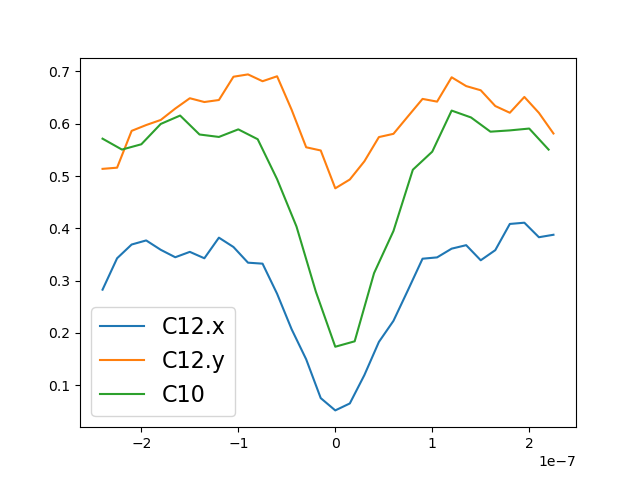

C12.y 2 33
C10 0 25


In [19]:
x_list_avg_cropped = []
y_list_avg_cropped = []

for i in range(len(coeff_list)):
    abr_coeff = coeff_list[i]
    idx = abr_list.index(abr_coeff)
    y_list = y_list_avg[i]
    
    # locate the minimum point and use that as the new zero point
    min_idx = np.argmax(y_list[40:60]) + 40
    
    # get the value list with zero point corrected
    abr_range = abr_lim[idx]
    abr_range_cropped = abr_lim_cropped[idx]
    value_list = [(i - min_idx) * abr_range / nsteps for i in range(nsteps)]
    cropped_idx = [i for i in range(nsteps) if abs(value_list[i]) < abr_lim_cropped[idx] / 2]
    
    print(abr_coeff, idx, len(cropped_idx))
    
    # create normalized x according to new range for each index in the cropped_idx
    for j in cropped_idx:
        x = [x_default[j] for j in range(len(x_default))]
        x[idx] = (value_list[j] + abr_range_cropped / 2) / abr_range_cropped
        y = y_list[j]
        x_list_avg_cropped.append(x)
        y_list_avg_cropped.append(1 - y)
    
    # make plot, to confirm that all the linescans are well aligned.
    plt.plot(value_list[cropped_idx[0]:cropped_idx[-1]], 1-y_list_avg[i][cropped_idx[0]:cropped_idx[-1]], label = abr_coeff)
    
plt.legend(fontsize = 16)

In [33]:
# y_list = np.ndarray.flatten(np.asarray(y_list_avg))
y_list = np.ndarray.flatten(np.asarray(y_list_avg))
print(y_list.shape)

(1200,)


In [34]:
# x_list = np.asarray(x_list_avg)
x_list = np.asarray(x_list_avg)
print(x_list.shape)

(1200, 12)


In [35]:
np.save('NionRelated/X_usim_linescan_100steps_50ms_bin1_rep5.npy', x_list)
np.save('NionRelated/Y_usim_linescan_100steps_50ms_bin1_rep5.npy', y_list)

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [36]:
# x_list = np.load('NionRelated/X_usim_linescan_100steps_50ms_bin1_rep5.npy')
# y_list = np.load('NionRelated/Y_usim_linescan_100steps_50ms_bin1_rep5.npy')

# combine the data from linescans and the data from a test GP run

X = pd.DataFrame(x_list)
Y = pd.DataFrame(y_list).squeeze()

print('Y.shape',Y.shape,'\nX.shape',X.shape)

Y.shape (1200,) 
X.shape (1200, 12)


In [37]:
from Modules.tfgp_trainer import tfgp_trainer
tf.compat.v1.disable_eager_execution()

In [38]:
Niter = 1500

t0 = time.time()
tfgp = tfgp_trainer(X, Y,verbose=0)

tfgp.train(lr=0.005, 
           niter=Niter,
           optimizer=[tf.compat.v1.train.AdamOptimizer, tf.optimizers.SGD, tf.optimizers.RMSprop][0],
           gradient_clipping=0,
           kernel=['rbf','matern32','matern52'][0],
           correlations = False,
           offset = False,
           monitor_period=None,
           monitor_gradient=None) 

tfgp_t = time.time()-t0
print ('took ',tfgp_t ,' seconds')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
100% (1500 of 1500) |####################| Elapsed Time: 0:04:03 Time:  0:04:03


took  243.80549216270447  seconds


<IPython.core.display.Javascript object>


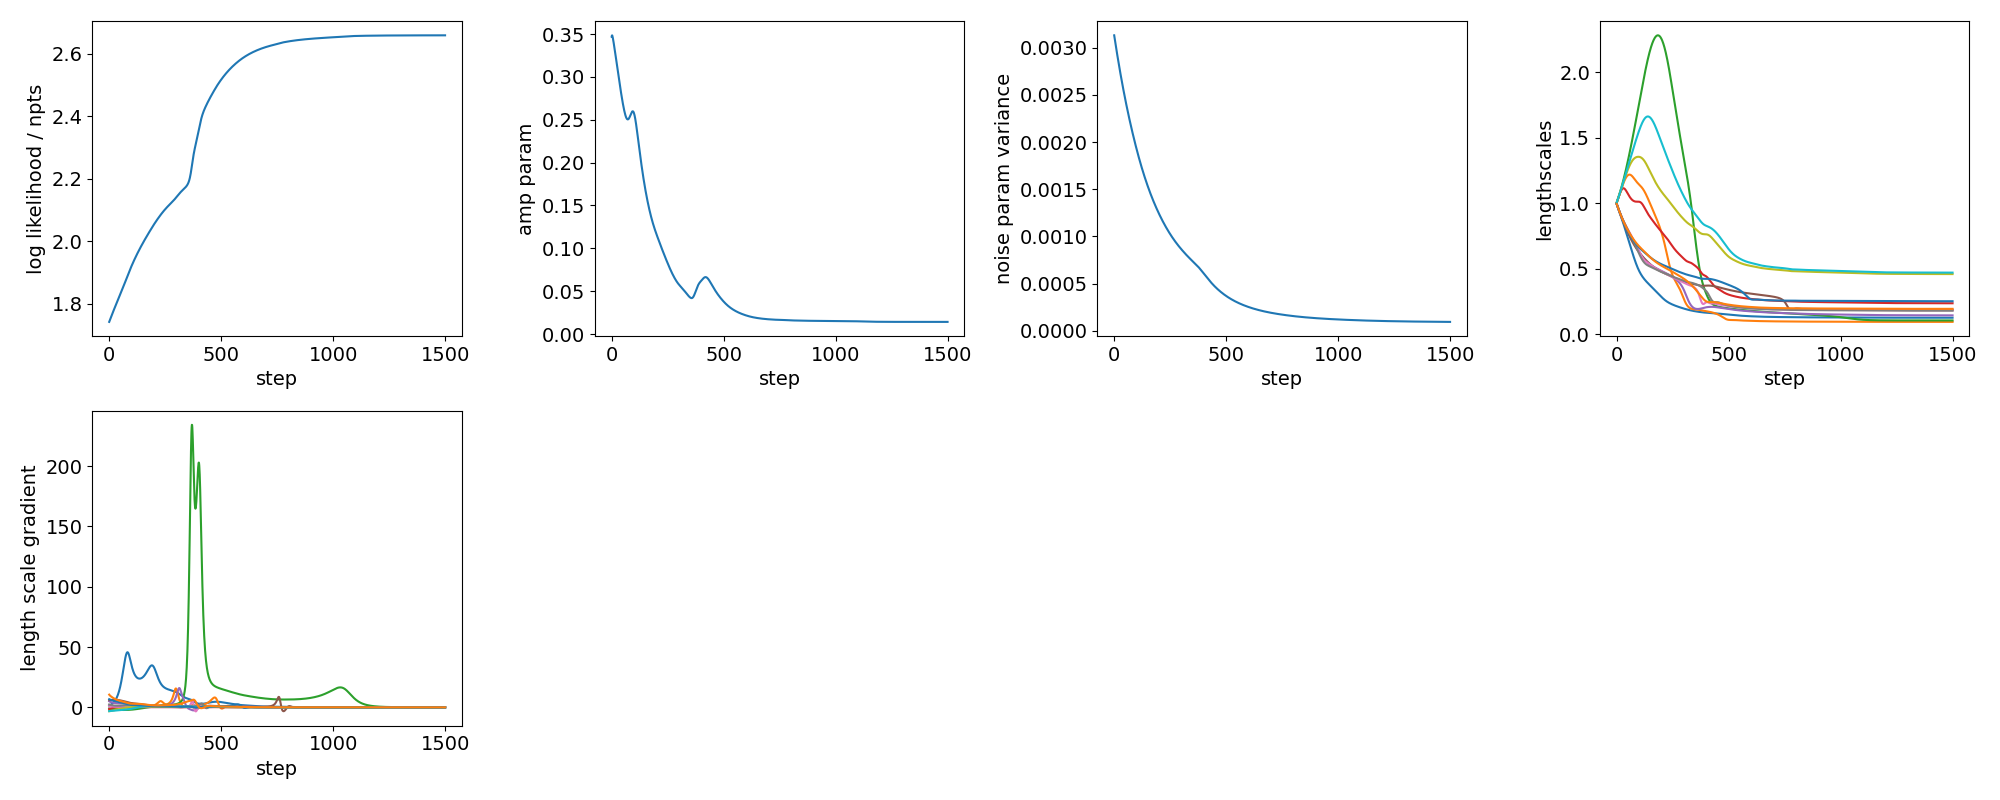

logLiklihod 3189.9140379963496 
 amp 0.014184874713380051 
 noise 9.574173605128506e-05 
 ls [0.12605038 0.09411417 0.10516314 0.23641675 0.14401461 0.18666332
 0.18296557 0.17951864 0.45944477 0.47053628 0.25192492 0.19379774]


In [39]:
from Modules.utils import GP_plot_results
tfgp_results = GP_plot_results(tfgp,Y)

In [40]:
from Modules.sk_trainer import sk_trainer
sk=sk_trainer()
sk.sk_train(X, Y, kernels=['rbf'], offset=False, verboseQ=True, saveQ=False)

********* 
 rbf
took  231.01421213150024  seconds
Inital kernel: 3.16**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=0.01)
Learned kernel: 0.109**2 * RBF(length_scale=[0.124, 0.0923, 0.103, 0.0875, 0.0659, 0.137, 0.179, 0.176, 0.45, 0.462, 0.0951, 0.189]) + WhiteKernel(noise_level=0.000164)
Log-marginal-likelihood: 3222.434


In [41]:
from Modules.gpy_trainer import gpy_trainer
gpy=gpy_trainer()
gpy.gpy_train(X, Y[:,None], kernels= ['rbf'], max_iters=5000, offset=False, verboseQ=True, saveQ=False)

********* 
 rbf
Optimization restart 1/5, f = -3201.7533570524497
Optimization restart 2/5, f = -3222.4335606265768
Optimization restart 3/5, f = -3189.987998058543
Optimization restart 4/5, f = -2674.146430799914
Optimization restart 5/5, f = -3215.0986876820334
took  44.549530267715454  seconds
Log-marginal-likelihood: 3222.434


In [42]:
# collect the results into a pandas dataframe to display
pd.DataFrame({"Param": ['time','negative log likelihood', 'amplitude', 'noise', 'offset'],
              "tfgp": [tfgp_t, tfgp_results['ll'], tfgp_results['amp_param'], tfgp_results['noise_param_variance'] , tfgp_results['offset_param']],
              "SK": [sk.sk_t, sk.results['ll'], sk.results['amp_param'], sk.results['noise_param_variance'] , sk.results['offset_param']],
              "GPy": [gpy.gpy_t, gpy.results['ll'], gpy.results['amp_param'], gpy.results['noise_param_variance'] , gpy.results['offset_param']],
             })


,Param,tfgp,SK,GPy
0,time,243.805492,231.014212,44.549530
1,negative log likelihood,-3189.914038,3222.433560,3222.433561
2,amplitude,0.014185,0.011913,0.011913
3,noise,0.000096,0.000164,0.000007
4,offset,NaN,NaN,NaN


In [43]:
print('Lengthscales Comparison')
pd.DataFrame({"": X.keys(),
#               "Param":['HP','HP diff','S6','S7','OBJ','S3','S4'],
              "tfgp": tfgp_results['length_scale_param'],
              "SK": sk.results['length_scale_param'] ,
              "GPy": gpy.results['length_scale_param']
             })

Lengthscales Comparison


,,tfgp,SK,GPy
0,0,0.126050,0.123609,0.123610
1,1,0.094114,0.092288,0.092291
2,2,0.105163,0.102872,0.102875
3,3,0.236417,0.087510,0.087507
4,4,0.144015,0.065890,0.065890
5,5,0.186663,0.137352,0.137362
6,6,0.182966,0.178773,0.178767
7,7,0.179519,0.176398,0.176401
8,8,0.459445,0.449672,0.449642
9,9,0.470536,0.461598,0.461608
